In [42]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

In [43]:
df = pd.read_csv("House_Data.csv")

In [44]:
df.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [45]:
price_q1 = df['SalePrice'].quantile(0.02)
price_q3 = df['SalePrice'].quantile(0.98)
df = df[(df['SalePrice'] >= price_q1) & (df['SalePrice'] <= price_q3)]

In [46]:
features = [
    'Gr Liv Area', 'Overall Qual', 'Garage Cars',
    'Total Bsmt SF', 'Year Built', 'Bedroom AbvGr',
    'Full Bath', 'Half Bath'
]

In [47]:
model_data = df[features + ['SalePrice']].dropna()
X = model_data[features]
y = np.log1p(model_data['SalePrice'])

In [48]:
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('model', GradientBoostingRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=4,
        min_samples_leaf=5,
        random_state=42
    ))
])

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05, max_depth=4,
                                           min_samples_leaf=5, n_estimators=500,
                                           random_state=42))])

In [50]:
y_pred = np.expm1(pipeline.predict(X_test))
y_true = np.expm1(y_test)

In [51]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

In [52]:
print(f"\nModel Performance:")
print(f"- MAE: ${mae:,.2f}")
print(f"- RMSE: ${rmse:,.2f}")
print(f"- R²: {r2:.3f}")


Model Performance:
- MAE: $17,118.94
- RMSE: $24,924.21
- R²: 0.862


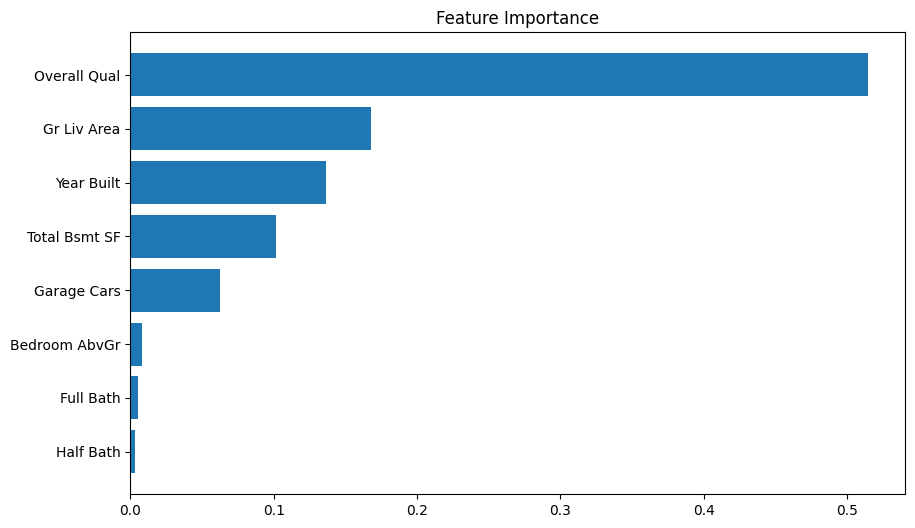

In [53]:
plt.figure(figsize=(10, 6))
importance = pipeline.named_steps['model'].feature_importances_
sorted_idx = np.argsort(importance)
plt.barh(range(len(sorted_idx)), importance[sorted_idx])
plt.yticks(range(len(sorted_idx)), np.array(features)[sorted_idx])
plt.title("Feature Importance")
plt.show()

In [ ]:
def predict_house_price():
    print("\nEnter house details for prediction:")

    def get_input(prompt, cast_func, min_val=None, max_val=None):
        while True:
            try:
                value = cast_func(input(prompt))
                if (min_val is not None and value < min_val) or (max_val is not None and value > max_val):
                    print(f"Value must be between {min_val} and {max_val}.")
                else:
                    return value
            except ValueError:
                print("Invalid input. Please enter a number.")

    gr_liv_area = get_input("Living area (sq ft): ", float, 300, 10000)
    overall_qual = get_input("Overall quality (1-10): ", int, 1, 10)
    garage_cars = get_input("Number of garage cars: ", int, 0, 5)
    total_bsmt_sf = get_input("Basement area (sq ft): ", float, 0, 3000)
    year_built = get_input("Year built: ", int, 1870, 2025)
    bedrooms = get_input("Bedrooms: ", int, 1, 10)
    full_bath = get_input("Full bathrooms: ", int, 0, 5)
    half_bath = get_input("Half bathrooms: ", int, 0, 3)

    input_data = pd.DataFrame([{
        'Gr Liv Area': gr_liv_area,
        'Overall Qual': overall_qual,
        'Garage Cars': garage_cars,
        'Total Bsmt SF': total_bsmt_sf,
        'Year Built': year_built,
        'Bedroom AbvGr': bedrooms,
        'Full Bath': full_bath,
        'Half Bath': half_bath
    }])

    pred_price = np.expm1(pipeline.predict(input_data))[0]
    price_per_sqft = pred_price / gr_liv_area

    print(f"\nPredicted Price: ${pred_price:,.2f}")
    print(f"Price per sqft: ${price_per_sqft:.2f}")


if __name__ == "__main__":
    print("\nHouse Price Prediction Model (Simplified)")
    print("-----------------------------------------")
    print(f"Performance: MAE=${mae:,.2f}, RMSE=${rmse:,.2f}, R²={r2:.3f}")

    while True:
        predict_house_price()
        cont = input("\nPredict another? (y/n): ").strip().lower()
        if cont != 'y':
            print("Exiting...")
            break


House Price Prediction Model (Simplified)
-----------------------------------------
Performance: MAE=$17,118.94, RMSE=$24,924.21, R²=0.862

Enter house details for prediction:
Value must be between 300 and 10000.
Value must be between 1 and 10.

Predicted Price: $178,492.98
Price per sqft: $44.62
Exiting...


In [57]:
from joblib import dump
dump(pipeline, 'house_price_model.joblib')

['house_price_model.joblib']